# ML Exercise 18
# GAN for MNIST images

Learn to generate digits from MNIST dataset.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import *
#from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
 
print("Tensorflow version %s" %tf.__version__)
 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.0
Found GPU at: /device:GPU:0


## Create the data set

Choose only one target digit

In [ ]:
def loadData(target_digit = 0):

  (X, Y), (_, _) = mnist.load_data()
  #print(X.shape)
  #print(Y.shape)

  X_buffer = []

  for i in range(0,Y.shape[0]):
    if Y[i]==target_digit:
      X_buffer.append(X[i])

  X_train = np.asarray(X_buffer)
  
  print("Loading data for digit %d:" %target_digit)
  #print(X.shape)
  print(X_train.shape)

  return X_train

# Test
#X = loadData()

## Define the GAN model

In [ ]:
class GAN():
 
    def __init__(self, target_digit=0, CNN_AE=True, latent_dim=128):

        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
 
        optimizer = Adam(lr=0.0002, beta_1=0.5)
 
        if CNN_AE:
            disc_fn = self.build_discriminator_CNN
            gen_fn = self.build_generator_CNN
        else:
            disc_fn = self.build_discriminator
            gen_fn = self.build_generator

        # Build and compile the discriminator
        self.discriminator = disc_fn()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer, metrics=['accuracy'])


        # Latent space dimension for generator
        self.latent_dim = latent_dim

        # Output layer for generator (sigmoid or tanh)
        self.Goutact = 'sigmoid'   # 'tanh' does not work with CNN ???

        # Build and compile the generator
        self.generator = gen_fn()
        #self.generator.compile(loss='mse', optimizer=optimizer)
  
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
 
        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
 
        # plot the models
        plot_model(self.discriminator, to_file='D.png', show_shapes=True, show_layer_names=True)
        plot_model(self.generator, to_file='G.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='GAN.png', show_shapes=True, show_layer_names=True)

        self.target = target_digit
        # Load the dataset
        self.X_train = loadData(self.target)

        # Scale data according to G output layer
        if (self.Goutact=='sigmoid'):
          # Rescale to [0,1]
          self.X_train = self.X_train.astype(np.float32) / 255.0
        else:
          # Rescale to [-1,1]
          self.X_train = (self.X_train.astype(np.float32) - 127.5) / 127.5
        
        self.X_train = np.expand_dims(self.X_train, axis=3)

        # Training epochs
        self.epoch = 0


    def build_generator(self):
 
        noise_shape = (self.latent_dim,)
 
        model = Sequential()
 
        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation=self.Goutact))
        model.add(Reshape(self.img_shape))
 
        #model.summary()
 
        return model

 
    def build_discriminator(self):
 
        img_shape = (self.img_rows, self.img_cols, self.channels)
 
        model = Sequential()
 
        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
 
        return model


    def build_generator_CNN(self):

        noise_shape = (self.latent_dim,)

        model = Sequential()
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        # upsample to 14x14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (7,7), activation=self.Goutact, padding='same'))

        return model


    # define the standalone discriminator model
    def build_discriminator_CNN(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()

        return model


    def train(self, epochs, batch_size=128, save_interval=100, show_img=False):

        half_batch = int(batch_size / 2)
 
        last_epoch = self.epoch + epochs

        self.save_imgs(self.epoch)
        self.d_loss = []
        self.g_loss = []

        while self.epoch < last_epoch:
 
            # ---------------------
            #  Train Discriminator
            # ---------------------
 
            # Select a random half batch of images from dataset (real = 1)
            idx = np.random.randint(0, self.X_train.shape[0], half_batch)
            imgs = self.X_train[idx]
            y_imgs = np.ones((half_batch, 1))
 
            # Generate a half batch of images (fake = 0)
            noise = np.random.normal(0, 1, (half_batch, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            y_gen = np.zeros((half_batch, 1))
 
            # Train the discriminator

            X, y = np.vstack((imgs, gen_imgs)), np.vstack((y_imgs, y_gen))
            d_loss = self.discriminator.train_on_batch(X, y)
            
            self.d_loss.append(d_loss[0])
 
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
 
            # The generator wants the discriminator to label the generated samples
            # as valid (real = 1)
            y_gennoise = np.ones((batch_size, 1))
 
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, y_gennoise)

            self.g_loss.append(g_loss)
 
            self.epoch += 1

            # If at save interval => save generated image samples
            if self.epoch % save_interval == 0:
                # Plot the progress                
                print ( "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (self.epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(self.epoch,show_img=False)


    def gen_imgs(self):
        cc = 10
        noise = np.random.normal(0, 1, (cc, self.latent_dim))
        self.imgs = self.generator.predict(noise)
 
        # Rescale images to [0,1]
        if self.Goutact=='tanh':
          self.imgs = 0.5 * self.imgs + 0.5


    def save_imgs(self, epoch, show_img=False):
        r, c = 2, 5
        self.gen_imgs()

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(self.imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("mnist_%d_%05d.png" %(self.target,epoch))
        if show_img:
            plt.show()
        plt.close()


    def show_images(self):
        r, c = 2, 5
        self.gen_imgs()
 
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(self.imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()


    def save_model(self):
      filename = 'G_model_%d_%05d.h5' %(self.target,self.epoch)
      self.generator.save(filename)
      filename = 'D_model_%d_%05d.h5' %(self.target,self.epoch)
      self.discriminator.save(filename)
      print("Models G/%s saved." %(filename))


    def load_model(self,epoch):
      self.epoch = epoch
      filename = 'G_model_%d_%05d.h5' %(self.target,self.epoch)
      self.generator.load_model(filename)
      filename = 'D_model_%d_%05d.h5' %(self.target,self.epoch)
      self.discriminator.save(filename)
      print("Models G/%s loaded." %(filename))



## Create the GAN

Choose the target_digit and the AE model (CNN_AE=True/False)

In [ ]:
# Create the model

gan = GAN(target_digit=3,CNN_AE=True,latent_dim=256)

Loading data for digit 3:
(6131, 28, 28)


## Train the GAN

In [ ]:
gan.train(epochs=10000, batch_size=128, save_interval=100)

100 [D loss: 0.326178, acc.: 89.06%] [G loss: 2.024123]
200 [D loss: 0.075983, acc.: 99.22%] [G loss: 2.679954]
300 [D loss: 0.660142, acc.: 57.81%] [G loss: 0.781640]
400 [D loss: 0.709002, acc.: 50.00%] [G loss: 0.724267]
500 [D loss: 0.693635, acc.: 50.78%] [G loss: 0.753803]
600 [D loss: 0.720762, acc.: 45.31%] [G loss: 0.743581]
700 [D loss: 0.697365, acc.: 53.12%] [G loss: 0.707879]
800 [D loss: 0.716828, acc.: 38.28%] [G loss: 0.684325]
900 [D loss: 0.749638, acc.: 30.47%] [G loss: 0.632763]
1000 [D loss: 0.689216, acc.: 50.78%] [G loss: 0.701780]
1100 [D loss: 0.685655, acc.: 53.12%] [G loss: 0.708880]
1200 [D loss: 0.700968, acc.: 52.34%] [G loss: 0.699455]
1300 [D loss: 0.682915, acc.: 57.81%] [G loss: 0.712637]
1400 [D loss: 0.694300, acc.: 50.00%] [G loss: 0.694888]
1500 [D loss: 0.690918, acc.: 52.34%] [G loss: 0.693029]
1600 [D loss: 0.695909, acc.: 49.22%] [G loss: 0.701133]
1700 [D loss: 0.689896, acc.: 52.34%] [G loss: 0.696042]
1800 [D loss: 0.693002, acc.: 50.00%] [G

## Plot losses

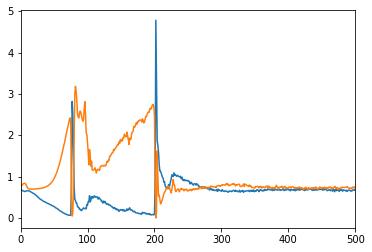

In [ ]:
plt.subplots()
plt.xlim(0,500)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()

## Generated images

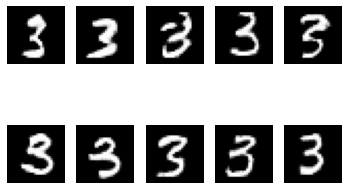

In [ ]:
gan.show_images()


## Save/load model



In [ ]:
gan.save_model()